In [1]:
!pip install wandb
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=6ede1bfc7165da1912c56a31cf27a7d710a56434fb1cf40ddcea2fe6006ffdfa
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 10.3 MB/s eta 0:00:00


In [1]:

import wandb
wandb.login()
import os
import torch
from torch import nn
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image as Image

from torchvision.transforms.functional import crop,hflip
from random import random
from torchmetrics.functional import peak_signal_noise_ratio as PSNR
from torchmetrics.functional import structural_similarity_index_measure as SSIM
# from skimage.metrics import peak_signal_noise_ratio as pr


wandb: Currently logged in as: xbojko. Use `wandb login --relogin` to force relogin


In [3]:
!pip install -U --no-cache-dir gdown --pre
!gdown "1N5PZBPEqwnL8MibSncMzVmekqSBV0azO&confirm=t"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1N5PZBPEqwnL8MibSncMzVmekqSBV0azO&confirm=t
To: /content/gopro.zip
100% 9.54G/9.54G [01:45<00:00, 90.7MB/s]


In [8]:
!unzip gopro.zip

Výstup streamovania bol skrátený na tento počet posledných riadkov: 5000.
  inflating: gopro/train/blur_gamma/GOPR0385_11_00_000165.png  
  inflating: __MACOSX/gopro/train/blur_gamma/._GOPR0385_11_00_000165.png  
  inflating: gopro/train/blur_gamma/GOPR0385_11_00_000171.png  
  inflating: __MACOSX/gopro/train/blur_gamma/._GOPR0385_11_00_000171.png  
  inflating: gopro/train/blur_gamma/GOPR0385_11_00_000159.png  
  inflating: __MACOSX/gopro/train/blur_gamma/._GOPR0385_11_00_000159.png  
  inflating: gopro/train/blur_gamma/GOPR0384_11_02_001333.png  
  inflating: __MACOSX/gopro/train/blur_gamma/._GOPR0384_11_02_001333.png  
  inflating: gopro/train/blur_gamma/GOPR0384_11_02_001327.png  
  inflating: __MACOSX/gopro/train/blur_gamma/._GOPR0384_11_02_001327.png  
  inflating: gopro/train/blur_gamma/GOPR0386_11_00_000345.png  
  inflating: __MACOSX/gopro/train/blur_gamma/._GOPR0386_11_00_000345.png  
  inflating: gopro/train/blur_gamma/GOPR0477_11_00_000053.png  
  inflating: __MACOSX/gopro/

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 12 08:53:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
class GoProDataset(Dataset):
    def __init__(self,root_dir,is_train=True,crop_size=256):
        self.root_dir = root_dir
        self.is_train = is_train
        self.crop_size = crop_size
        self.img_names = os.listdir(os.path.join(root_dir, 'blur/'))
        self.img_names = list(filter(lambda img: img[-3:len(img)] == "png" or img[-3:len(img)] == "jpg" or  img[-4:len(img)] == "jpeg",self.img_names))
        self.img_names.sort()
    
    def print_list(self):
        print(self.img_names)
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, index):
        blurred_img_path = os.path.join(self.root_dir, 'blur', self.img_names[index])
        blurred_img = read_image(blurred_img_path)

        label_img_path = os.path.join(self.root_dir, 'sharp', self.img_names[index])
        label_img = read_image(label_img_path)

        return self.transform(blurred_img,label_img)
    
    def transform(self,blurred_img,label_img):
        blurred_img = blurred_img.to(torch.float32) / 255
        label_img = label_img.to(torch.float32) / 255

        if self.is_train:
            i, j, h, w = transforms.RandomCrop.get_params(blurred_img, output_size=(self.crop_size, self.crop_size))
            blurred_img = crop(blurred_img,i, j, h, w)
            label_img = crop(label_img,i, j, h, w)

            if random() < 0.5:
                blurred_img = hflip(blurred_img)
                label_img = hflip(label_img)

        return blurred_img,label_img
        



In [3]:
class ResidualBlock(nn.Module):
    def __init__(self,in_ch,out_ch,kernel_size,use_batchnorm=False):
        super(ResidualBlock,self).__init__()
        padding = (kernel_size - 1) // 2

        self.block = nn.Sequential()
        self.block.add_module("conv_1",nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=1, padding=padding))
        if use_batchnorm: 
            self.block.add_module("bn_1",nn.BatchNorm2d(out_ch))
        self.block.add_module("relu_1",nn.ReLU(inplace=True))
        self.block.add_module("conv_2",nn.Conv2d(out_ch, out_ch, kernel_size=kernel_size, stride=1, padding=padding))
        if use_batchnorm: 
            self.block.add_module("bn_2",nn.BatchNorm2d(out_ch))
    
    def forward(self,input):
        return self.block(input) + input


class ResBlockNoSkip(nn.Module):
    def __init__(self,in_ch):
        super(ResBlockNoSkip,self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch,in_ch,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch,in_ch,kernel_size=3,stride=1,padding=1),
        )
    def forward(self,input):
        return self.block(input)


class RDUBlock(nn.Module):
    def __init__(self,in_ch,kernel_size):
        super(RDUBlock,self).__init__()
        #3 2 1
        #5 2 2
        padding = (kernel_size - 1) // 2
        self.block = nn.Sequential(
            nn.Conv2d(in_ch,in_ch*2, kernel_size=kernel_size, stride=2, padding=padding),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_ch*2,in_ch,kernel_size=4, stride=2,padding=1),
        )
    def forward(self,input):
        return self.block(input) + input

class RUDBlock(nn.Module):
    def __init__(self,in_ch,kernel_size):
        super(RUDBlock,self).__init__()
        #3 2 1
        #5 2 2
        padding = (kernel_size - 1) // 2
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_ch,in_ch//2,kernel_size=4, stride=2,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch//2,in_ch, kernel_size=kernel_size, stride=2, padding=padding),
        )
        
    def forward(self,input):
        return self.block(input) + input


class DenseBlock(nn.Module):
    def __init__(self,in_ch):
        super(DenseBlock,self).__init__()
        self.resblock1 = ResBlockNoSkip(in_ch=in_ch)
        self.resblock2 = ResBlockNoSkip(in_ch=in_ch)
        self.resblock3 = ResBlockNoSkip(in_ch=in_ch)
        self.resblock4 = ResBlockNoSkip(in_ch=in_ch)
    
    def forward(self,input):
        res1 = self.resblock1(input)
        res2 = self.resblock2(input + res1)
        res3 = self.resblock3(input + res1 + res2)
        res4 = self.resblock4(input + res1 + res2 + res3)

        return input + res1 + res2 + res3 + res4



In [ ]:
n = nn.UpsamplingNearest2d(scale_factor=2)
summary(n,(32,1280,720))

Layer (type:depth-idx)                   Output Shape              Param #
└─UpsamplingNearest2d: 0-1               [-1, 32, 2560, 1440]      --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 112.50
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 112.50


Layer (type:depth-idx)                   Output Shape              Param #
└─UpsamplingNearest2d: 0-1               [-1, 32, 2560, 1440]      --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 112.50
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 112.50

In [ ]:
class MyEncoderDecoder(nn.Module):
    def __init__(self,use_batchnorm=False) -> None:
        super(MyEncoderDecoder,self).__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1,padding=1), #nezmensuje obrazok
            nn.ReLU(inplace=True),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
        )

        self.encoder2 = nn.Sequential(
            nn.MaxPool2d((2,2)), #zmensuje obrazok
            nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0), # zväčši pocet channelov
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
        )

        self.encoder3 = nn.Sequential(
            nn.MaxPool2d((2,2)), #zmensuje obrazok
            nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0), # zväčši pocet channelov
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
        )

        #Decoder
        self.decoder3 = nn.Sequential(
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            nn.UpsamplingNearest2d(scale_factor=2)
        )

        self.conv1x1_1 = nn.Conv2d(128 + 64, 64, kernel_size=1, stride=1, padding=0)
        self.decoder2 = nn.Sequential(
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            nn.UpsamplingNearest2d(scale_factor=2)
        )

        self.conv1x1_2 = nn.Conv2d(64 + 32, 32, kernel_size=1, stride=1, padding=0)
        self.decoder1 = nn.Sequential(
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            nn.Conv2d(32, 3, kernel_size=3, stride=1,padding=1), #nezmensuje obrazok
        )

        
    def forward(self,input):
        encoder1_out = self.encoder1(input)
        encoder2_out = self.encoder2(encoder1_out)
        encoded = self.encoder3(encoder2_out)

        decoded1 = self.decoder3(encoded)
        decoded1 = self.conv1x1_1(torch.cat([decoded1, encoder2_out], dim=1))
        decoded1 = self.decoder2(decoded1)
        decoded1 = self.conv1x1_2(torch.cat([decoded1, encoder1_out], dim=1))
        decoded1 = self.decoder1(decoded1)

        encoded_rotated = encoded.transpose(2,3).flip(2)
        encoder1_out_rotated = encoder1_out.transpose(2,3).flip(2)
        encoder2_out_rotated = encoder2_out.transpose(2,3).flip(2)

        decoded2 = self.decoder3(encoded_rotated)
        decoded2 = self.conv1x1_1(torch.cat([decoded2, encoder2_out_rotated], dim=1))
        decoded2 = self.decoder2(decoded2)
        decoded2 = self.conv1x1_2(torch.cat([decoded2, encoder1_out_rotated], dim=1))
        decoded2 = self.decoder1(decoded2)

        decoded2 = decoded2.transpose(2,3).flip(3)

        return decoded1 + decoded2 + input



In [5]:
class MyEncoderDecoder(nn.Module):
    def __init__(self,use_batchnorm=False) -> None:
        super(MyEncoderDecoder,self).__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1,padding=1), #nezmensuje obrazok
            nn.ReLU(inplace=True),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
        )

        self.encoder2 = nn.Sequential(
            nn.MaxPool2d((2,2)), #zmensuje obrazok
            nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0), # zväčši pocet channelov
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),  
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),   
        )

        self.encoder3 = nn.Sequential(
            nn.MaxPool2d((2,2)), #zmensuje obrazok
            nn.Conv2d(64, 96, kernel_size=1, stride=1, padding=0), # zväčši pocet channelov
            RDUBlock(96,kernel_size=3),
            RDUBlock(96,kernel_size=3),
            RDUBlock(96,kernel_size=3),
            RDUBlock(96,kernel_size=3),
            RDUBlock(96,kernel_size=3),
        )
        
        self.encoder4 = nn.Sequential(
            nn.MaxPool2d((2,2)), #zmensuje obrazok
            nn.Conv2d(96, 128, kernel_size=1, stride=1, padding=0), # zväčši pocet channelov
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
        )

        #Decoder
        self.decoder4 = nn.Sequential(
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            nn.UpsamplingNearest2d(scale_factor=2)
        )

        self.conv1x1_1 = nn.Conv2d(128 + 96, 96, kernel_size=1, stride=1, padding=0)
        self.decoder3 = nn.Sequential(
            RDUBlock(96,kernel_size=3),
            RDUBlock(96,kernel_size=3),
            RDUBlock(96,kernel_size=3),
            RDUBlock(96,kernel_size=3),
            RDUBlock(96,kernel_size=3),
            nn.UpsamplingNearest2d(scale_factor=2)
        )

        self.conv1x1_2 = nn.Conv2d(96 + 64, 64, kernel_size=1, stride=1, padding=0)
        self.decoder2 = nn.Sequential(
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            nn.UpsamplingNearest2d(scale_factor=2)
        )

        self.conv1x1_3 = nn.Conv2d(64 + 32, 32, kernel_size=1, stride=1, padding=0)
        self.decoder1 = nn.Sequential(
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            nn.Conv2d(32, 3, kernel_size=3, stride=1,padding=1), #nezmensuje obrazok
        )

        
    def forward(self,input):
        encoder1_out = self.encoder1(input)
        encoder2_out = self.encoder2(encoder1_out)
        encoder3_out = self.encoder3(encoder2_out)
        encoded = self.encoder4(encoder3_out)

        decoded1 = self.decoder4(encoded)
        decoded1 = self.conv1x1_1(torch.cat([decoded1, encoder3_out], dim=1))
        decoded1 = self.decoder3(decoded1)
        decoded1 = self.conv1x1_2(torch.cat([decoded1, encoder2_out], dim=1))
        decoded1 = self.decoder2(decoded1)
        decoded1 = self.conv1x1_3(torch.cat([decoded1, encoder1_out], dim=1))
        decoded1 = self.decoder1(decoded1)

        encoded_rotated = encoded.transpose(2,3).flip(2)
        encoder1_out_rotated = encoder1_out.transpose(2,3).flip(2)
        encoder2_out_rotated = encoder2_out.transpose(2,3).flip(2)
        encoder3_out_rotated = encoder3_out.transpose(2,3).flip(2)

        decoded2 = self.decoder4(encoded_rotated)
        decoded2 = self.conv1x1_1(torch.cat([decoded2, encoder3_out_rotated], dim=1))
        decoded2 = self.decoder3(decoded2)
        decoded2 = self.conv1x1_2(torch.cat([decoded2, encoder2_out_rotated], dim=1))
        decoded2 = self.decoder2(decoded2)
        decoded2 = self.conv1x1_3(torch.cat([decoded2, encoder1_out_rotated], dim=1))
        decoded2 = self.decoder1(decoded2)

        decoded2 = decoded2.transpose(2,3).flip(3)

        return decoded1 + decoded2 + input

In [ ]:
class MyEncoderDecoder(nn.Module):
    def __init__(self,use_batchnorm=False) -> None:
        super(MyEncoderDecoder,self).__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1,padding=1), #nezmensuje obrazok
            nn.ReLU(inplace=True),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
        )

        self.encoder2 = nn.Sequential(
            nn.MaxPool2d((2,2)), #zmensuje obrazok
            nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0), # zväčši pocet channelov
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            
        )

        self.encoder3 = nn.Sequential(
            nn.MaxPool2d((2,2)), #zmensuje obrazok
            nn.Conv2d(64, 96, kernel_size=1, stride=1, padding=0), # zväčši pocet channelov
            RDUBlock(96,kernel_size=3),
            RDUBlock(96,kernel_size=3),
        )
        
        self.encoder4 = nn.Sequential(
            nn.MaxPool2d((2,2)), #zmensuje obrazok
            nn.Conv2d(96, 128, kernel_size=1, stride=1, padding=0), # zväčši pocet channelov
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
        )

        #Decoder
        self.decoder4 = nn.Sequential(
            RDUBlock(128,kernel_size=3),
            RDUBlock(128,kernel_size=3),
            nn.UpsamplingNearest2d(scale_factor=2)
        )

        self.conv1x1_1 = nn.Conv2d(128 + 96, 96, kernel_size=1, stride=1, padding=0)
        self.decoder3 = nn.Sequential(
            RDUBlock(96,kernel_size=3),
            RDUBlock(96,kernel_size=3),
            nn.UpsamplingNearest2d(scale_factor=2)
        )

        self.conv1x1_2 = nn.Conv2d(96 + 64, 64, kernel_size=1, stride=1, padding=0)
        self.decoder2 = nn.Sequential(
            RDUBlock(64,kernel_size=3),
            RDUBlock(64,kernel_size=3),
            nn.UpsamplingNearest2d(scale_factor=2)
        )

        self.conv1x1_3 = nn.Conv2d(64 + 32, 32, kernel_size=1, stride=1, padding=0)
        self.decoder1 = nn.Sequential(
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            RDUBlock(32,kernel_size=3),
            nn.Conv2d(32, 3, kernel_size=3, stride=1,padding=1), #nezmensuje obrazok
        )

        
    def forward(self,input):
        encoder1_out = self.encoder1(input)
        encoder2_out = self.encoder2(encoder1_out)
        encoder3_out = self.encoder3(encoder2_out)
        encoded = self.encoder4(encoder3_out)

        decoded1 = self.decoder4(encoded)
        decoded1 = self.conv1x1_1(torch.cat([decoded1, encoder3_out], dim=1))
        decoded1 = self.decoder3(decoded1)
        decoded1 = self.conv1x1_2(torch.cat([decoded1, encoder2_out], dim=1))
        decoded1 = self.decoder2(decoded1)
        decoded1 = self.conv1x1_3(torch.cat([decoded1, encoder1_out], dim=1))
        decoded1 = self.decoder1(decoded1)

        encoded_rotated = encoded.transpose(2,3).flip(2)
        encoder1_out_rotated = encoder1_out.transpose(2,3).flip(2)
        encoder2_out_rotated = encoder2_out.transpose(2,3).flip(2)
        encoder3_out_rotated = encoder3_out.transpose(2,3).flip(2)


        decoded2 = self.decoder4(encoded_rotated)
        decoded2 = self.conv1x1_1(torch.cat([decoded2, encoder3_out_rotated], dim=1))
        decoded2 = self.decoder3(decoded2)
        decoded2 = self.conv1x1_2(torch.cat([decoded2, encoder2_out_rotated], dim=1))
        decoded2 = self.decoder2(decoded2)
        decoded2 = self.conv1x1_3(torch.cat([decoded2, encoder1_out_rotated], dim=1))
        decoded2 = self.decoder1(decoded2)

        decoded2 = decoded2.transpose(2,3).flip(3)

        return decoded1 + decoded2 + input

In [7]:
def debug_model(input=(3,1280,720)):
    model = MyEncoderDecoder(use_batchnorm=False)
    summary(model,input)
debug_model() 

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 32, 1280, 720]       --
|    └─Conv2d: 2-1                            [-1, 32, 1280, 720]       896
|    └─ReLU: 2-2                              [-1, 32, 1280, 720]       --
|    └─RDUBlock: 2-3                          [-1, 32, 1280, 720]       --
|    |    └─Sequential: 3-1                   [-1, 32, 1280, 720]       51,296
|    └─RDUBlock: 2-4                          [-1, 32, 1280, 720]       --
|    |    └─Sequential: 3-2                   [-1, 32, 1280, 720]       51,296
|    └─RDUBlock: 2-5                          [-1, 32, 1280, 720]       --
|    |    └─Sequential: 3-3                   [-1, 32, 1280, 720]       51,296
|    └─RDUBlock: 2-6                          [-1, 32, 1280, 720]       --
|    |    └─Sequential: 3-4                   [-1, 32, 1280, 720]       51,296
|    └─RDUBlock: 2-7                          [-1, 32, 1280, 720]       --
|  

In [8]:
class Acumulator():
    def __init__(self):
        # self.average_items = []
        self.iteration = 0;
        self.value_sum = 0;

    def get_epoch_average(self):
        avrg = self.value_sum / self.iteration

        return avrg
    
    def add_value(self,value):
        self.iteration = self.iteration + 1
        self.value_sum = self.value_sum + value

    def reset(self):
        self.iteration = 0
        self.value_sum = 0


In [9]:
def start(device, debug_mode, resume_id, init, config):
    
    dataset_train = GoProDataset(
        config["dataset_dir"] + 'train/',
        is_train=True,
        crop_size=config["crop_size"]
    )
    dataset_test = GoProDataset(
        config["dataset_dir"] + 'test/',
        is_train=False
    )
    train_img_loader = DataLoader(
        dataset_train,
        batch_size=config["batch_size"],
        shuffle=True
    )
    test_img_loader = DataLoader(
        dataset_test,
        batch_size=1,
        shuffle=False
    )

    model = MyEncoderDecoder(use_batchnorm=False).to(device=device)
    loss_fn = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(),lr=config["lr"])
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[500,1000,1500],gamma=0.5)

    start_epoch = 1
    train_size = len(train_img_loader.dataset)
    loss_acumulator = Acumulator()
    psnr_train_acumulator = Acumulator()
    psnr_test_acumulator = Acumulator()

    if resume_id:
        checkpoint = torch.load('./model_saving/'+init["name"]+'.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint["epoch"] + 1
        # lr_scheduler.load_state_dict(checkpoint['lr_sheduler_state_dict'])
        print('Resuming training of '+init["name"]+' starting at epoch:',start_epoch)
    else:
        print("No resume training. Starting training from begining at epoch: ",start_epoch)


    if not debug_mode:
        id = None
        if not resume_id:
            id = wandb.util.generate_id()
            config["resume_id"] = id
            
        wandb.init(
            project=init["project"],
            name=init["name"],
            notes=init["notes"],
            tags=init["tags"],
            config=config,
            id=resume_id if resume_id else id,
            resume="allow" if resume_id else None
        )
        wandb.define_metric("epoch")
        wandb.define_metric("avg_loss", step_metric="epoch")
        wandb.define_metric("avg_psnr", step_metric="epoch")
        wandb.define_metric("avg_valid_psnr", step_metric="epoch")
   
   # Epochs ##########
    for epoch in range(start_epoch,config["epochs"]+1):
        print(f"Epoch {epoch} -------------------------------")

        #Training iterations ##############
        model.train()
        for batch, (X,Y) in enumerate(train_img_loader):
            X = X.to(device)
            Y = Y.to(device)

            #forward
            optimizer.zero_grad() 
            pred = model(X)

            #loss
            loss = loss_fn(pred,Y)
            loss_acumulator.add_value(loss.item())
            
            #psnr
            pred = torch.clamp(pred,0,1)
            psnr_val = PSNR(pred,Y,data_range=1)
            psnr_train_acumulator.add_value(psnr_val.item())

            #backward
            loss.backward() 
            optimizer.step()
            
            # Loss printing #####
            if batch % config["loss_print_freq"] == 0:
                print(f"loss: {loss.item():>7f}  [{batch * len(X):>5d}/{train_size:>5d}]")

        # Loging training epoch metrics
        print(f"Epoch {epoch} --- Average loss: {loss_acumulator.get_epoch_average()} Average psnr: {psnr_train_acumulator.get_epoch_average()}")
        log = {
            "epoch":epoch,
            "avg_loss": loss_acumulator.get_epoch_average(),
            "avg_psnr": psnr_train_acumulator.get_epoch_average()
        }
        loss_acumulator.reset()
        psnr_train_acumulator.reset()
        
        #Validation ##############
        if (config["validation_freq"] != 0 and epoch % config["validation_freq"] == 0) or (config["validation_freq"] != 0 and epoch == 1):
            print(f"Validating {epoch} -------------------------------")
            model.eval()
            
            for batch, (X,Y) in enumerate(test_img_loader):
                X = X.to(device)
                Y = Y.to(device)
                
                pred = model(X)
                
                pred = torch.clamp(pred,0,1)
                psnr_val = PSNR(pred,Y,data_range=1)
                psnr_test_acumulator.add_value(psnr_val.item())
        
            print("Average validation PSNR:",psnr_test_acumulator.get_epoch_average())
            log["avg_valid_psnr"] = psnr_test_acumulator.get_epoch_average()
            psnr_test_acumulator.reset()
        
        #Saving model
        if (config["saving_freq"] != 0 and epoch % config["saving_freq"] == 0) or (epoch == 1 and config["validation_freq"] != 0):
            print("Saving model...")
            if not os.path.exists('./model_saving/'):
                os.makedirs('./model_saving/')
            torch.save({
                'epoch': epoch, #uloži sa cislo posledne vykonaneho epochu
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                # 'lr_sheduler_state_dict': lr_scheduler.state_dict()
            },'./model_saving/'+init["name"]+".pth")

        ##Upload logs and sheduler step after epoch
        if not debug_mode:
            wandb.log(log)
        # lr_scheduler.step()

    wandb.finish()
    print("All done!")


In [10]:
device = "mps"
if torch.cuda.is_available():
    device = "cuda"
    print("Device name:", torch.cuda.get_device_name(0))

print("Running on:",device)


Running on: mps


In [16]:
start(
    device=device,
    debug_mode=False,
    resume_id= "wzth8wcr",
    init={
        "project": "bc-deblurring-model",
        "name": "5-5-5-5RDU-2decoder-max-nearest",
        "notes": "My first experiment",
        "tags": ["1encoder-2decoder"]
    },
    config={
        "dataset_dir": '/content/gopro/',
        "epochs": 210,
        "batch_size": 4,
        "lr": 0.0001,
        "crop_size":256,
        "loss_print_freq": 50,
        "validation_freq": 10, #po každom n-tom trenovacom epochu
        "saving_freq":1 #po každom n-tom epochu
})
#3encoder standart
#epoch 4min 52s
#valid 7min 46s

#4encoder viac vrstiev viac parametrov
#epoch 4min 49s
#valid 7min 38s

#4encoder rovnako vrstiev trocha menej parametrov
#epoch 4min 10s
#valid 6min 57s

#epoch 6min 52s


Resuming training of 5-5-5-5RDU-2decoder-max-nearest starting at epoch: 201


Epoch 201 -------------------------------
loss: 0.020510  [    0/ 2103]
loss: 0.021362  [  200/ 2103]
loss: 0.016609  [  400/ 2103]
loss: 0.022815  [  600/ 2103]
loss: 0.013927  [  800/ 2103]
loss: 0.018495  [ 1000/ 2103]
loss: 0.014005  [ 1200/ 2103]
loss: 0.010178  [ 1400/ 2103]
loss: 0.017612  [ 1600/ 2103]
loss: 0.018054  [ 1800/ 2103]
loss: 0.017357  [ 2000/ 2103]
Epoch 201 --- Average loss: 0.019640449650528993 Average psnr: 29.45833205814144
Saving model...
Epoch 202 -------------------------------
loss: 0.014306  [    0/ 2103]
loss: 0.013876  [  200/ 2103]
loss: 0.012501  [  400/ 2103]
loss: 0.016322  [  600/ 2103]
loss: 0.012859  [  800/ 2103]
loss: 0.013009  [ 1000/ 2103]
loss: 0.016654  [ 1200/ 2103]
loss: 0.024679  [ 1400/ 2103]
loss: 0.027773  [ 1600/ 2103]
loss: 0.016984  [ 1800/ 2103]
loss: 0.023205  [ 2000/ 2103]
Epoch 202 --- Average loss: 0.01947046336257554 Average psnr: 29.502748405978707
Saving model...
Epoch 203 -------------------------------
loss: 0.033137  [   

All done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR with prediction: 29.574932098388672
PSNR with blur: 24.596328735351562


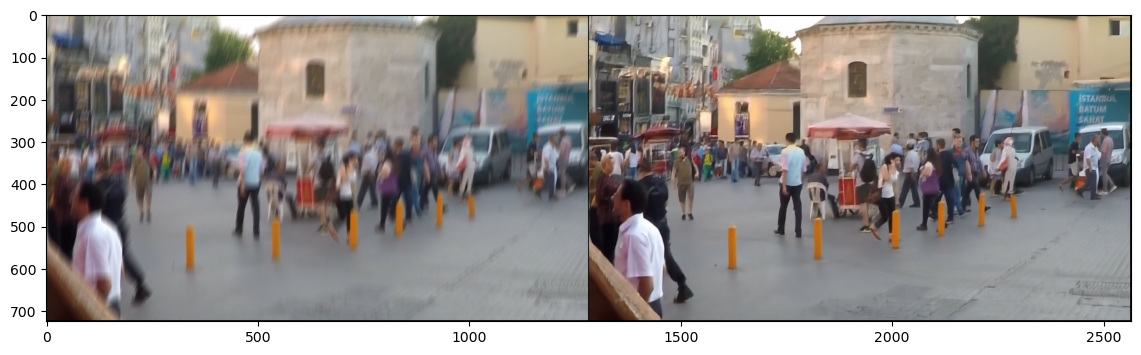

PSNR with prediction: 28.407548904418945
PSNR with blur: 24.71611976623535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


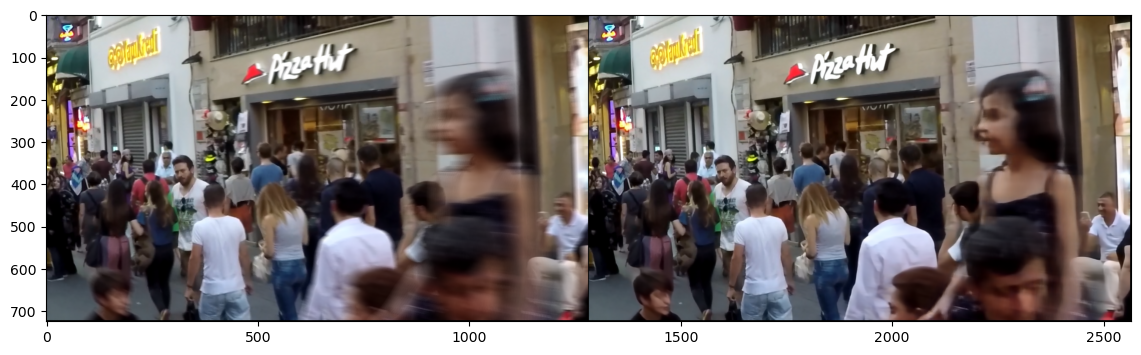

PSNR with prediction: 29.47021484375
PSNR with blur: 24.632076263427734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


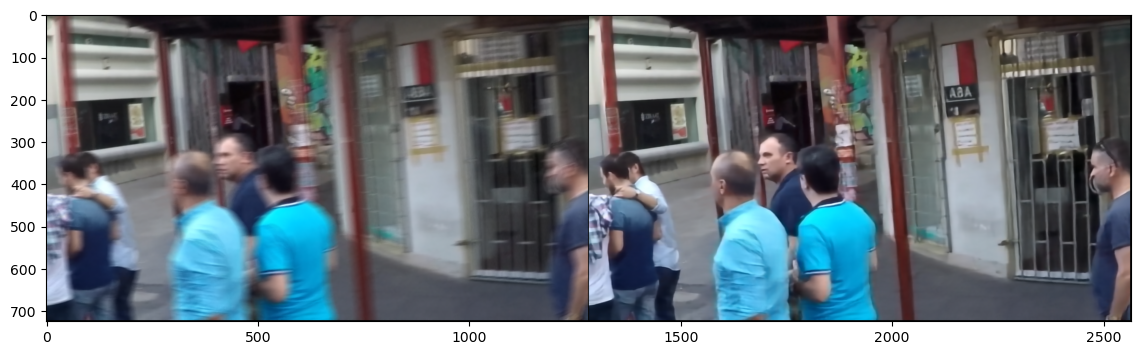

PSNR with prediction: 26.973981857299805
PSNR with blur: 24.795331954956055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


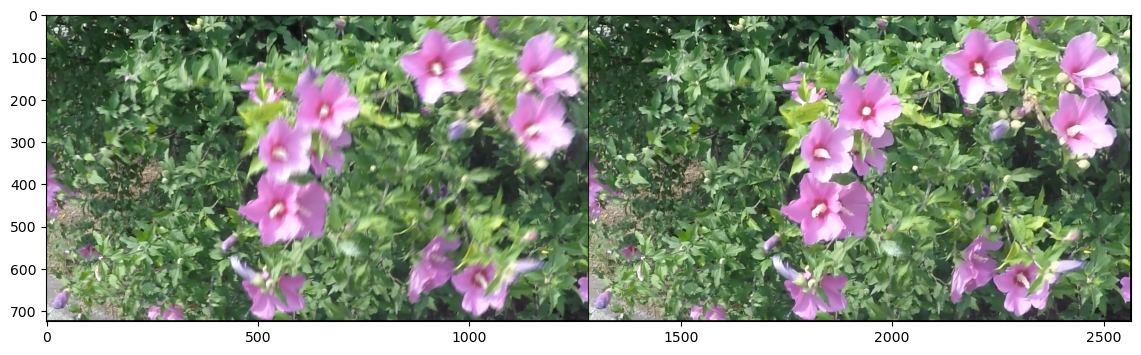

PSNR with prediction: 31.632593154907227
PSNR with blur: 27.545934677124023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


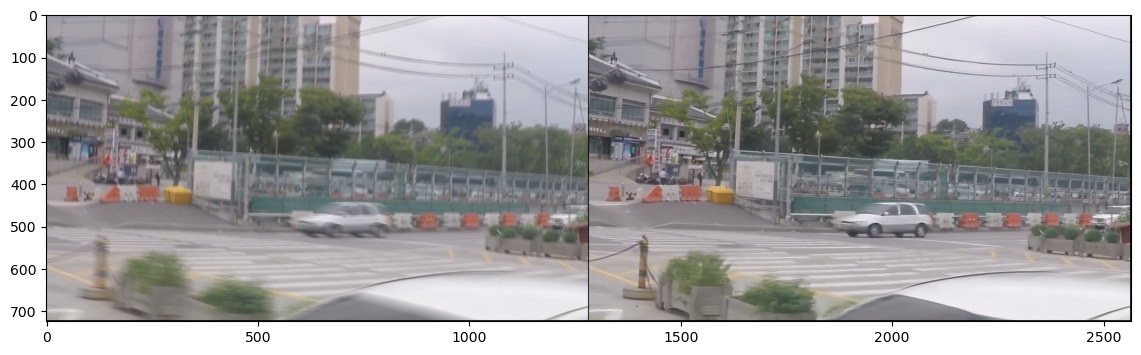

PSNR with prediction: 28.427352905273438
PSNR with blur: 26.222951889038086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


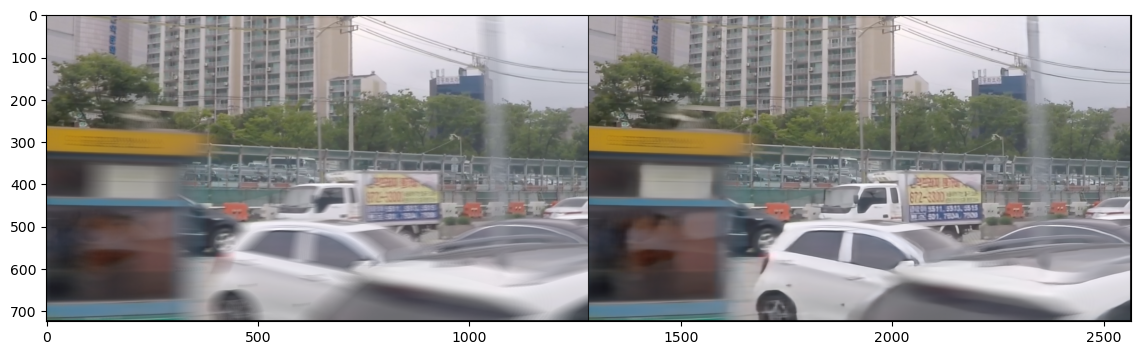

PSNR with prediction: 29.728185653686523
PSNR with blur: 25.592571258544922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


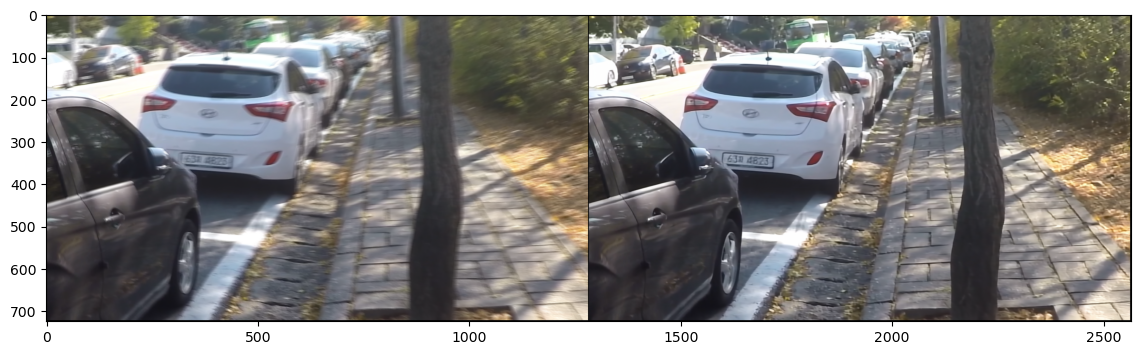

PSNR with prediction: 23.47731590270996
PSNR with blur: 20.401384353637695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


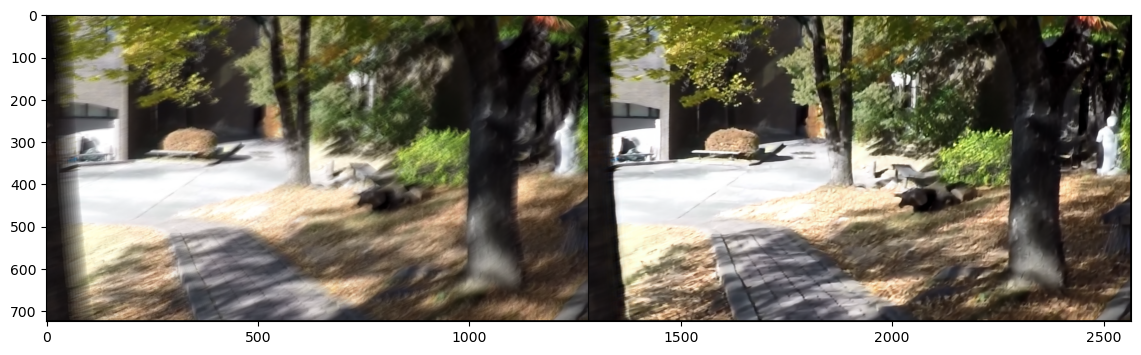

PSNR with prediction: 25.498634338378906
PSNR with blur: 21.12152099609375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


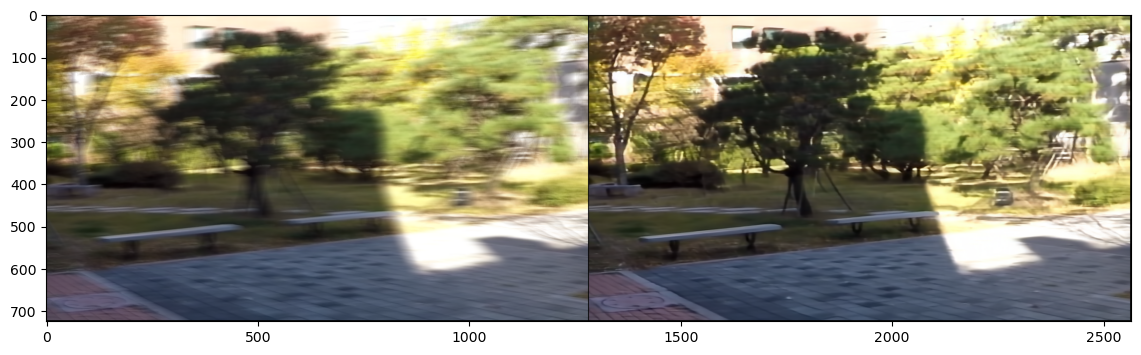

PSNR with prediction: 24.33880043029785
PSNR with blur: 21.50597381591797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


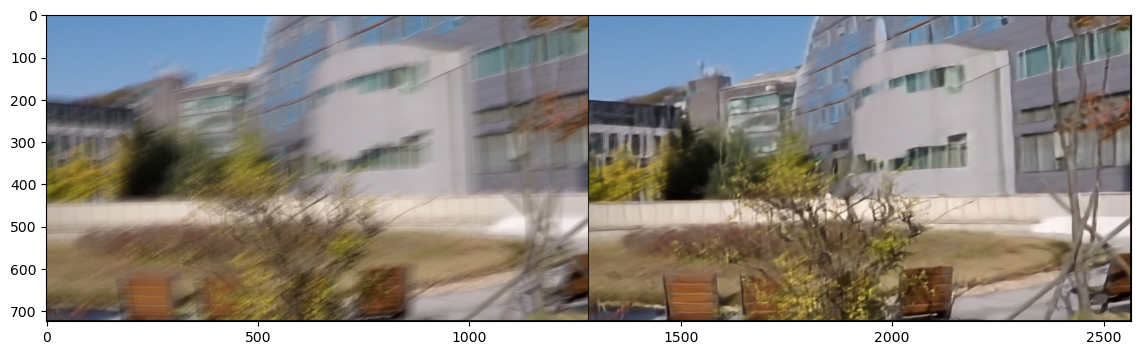

PSNR with prediction: 27.079280853271484
PSNR with blur: 22.616409301757812


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


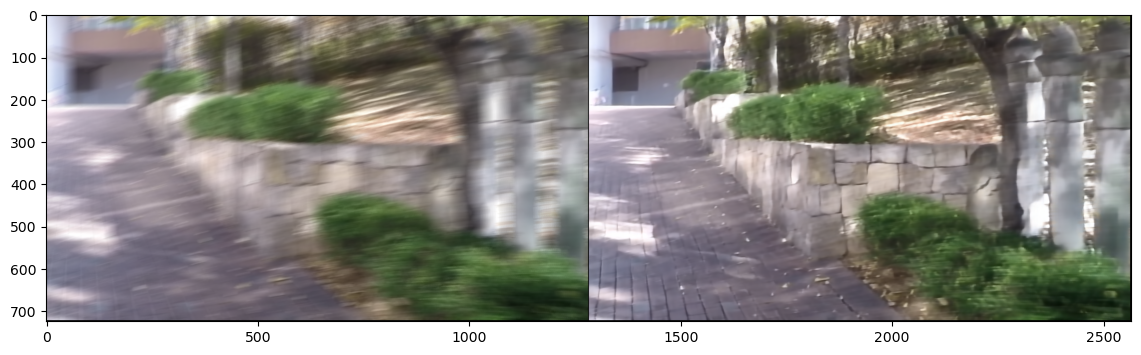

PSNR with prediction: 39.320526123046875
PSNR with blur: 38.35508728027344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


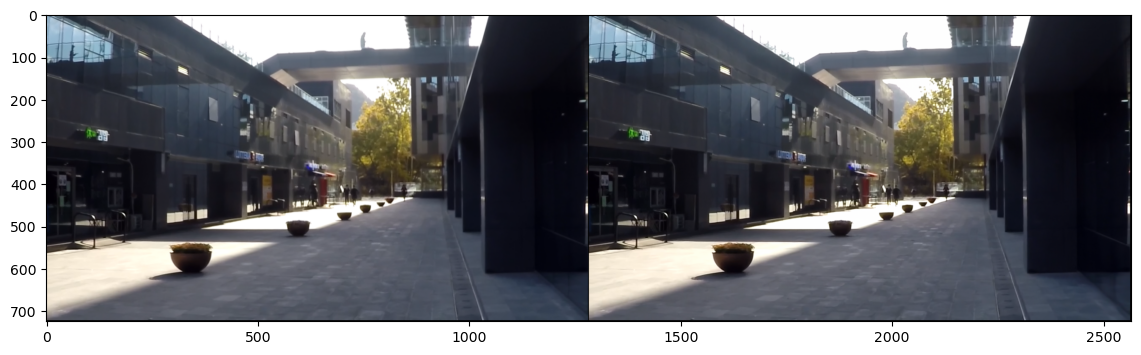

In [15]:
def test_bluring_results(dataset_dir,start_idx=1,init_name=""):

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        print("Device name:", torch.cuda.get_device_name(0))
    

    model = MyEncoderDecoder().to(device=device)

    checkpoint = torch.load('./model_saving/'+init_name+'.pth',map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])

    dataset_test = GoProDataset(
        dataset_dir + 'test/',
        is_train=False
    )

    model.eval()
    for idx in range(start_idx,dataset_test.__len__(),100):

        X = dataset_test[idx][0].to(device)
        Y = dataset_test[idx][1].to(device)

        pred = model(X[None,:]).squeeze(0)

        psnr_pred = PSNR(pred,Y,data_range=1)
        psnr_blur_input = PSNR(X,Y,data_range=1)

        print("PSNR with prediction:",psnr_pred.item())
        print("PSNR with blur:",psnr_blur_input.item())
     
        imgs_tensor = torch.stack([
            X,
            pred
        ])

        grid = make_grid(imgs_tensor,2)
        plt.figure(figsize = (14,8))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.show()


test_bluring_results(
    dataset_dir="./datasets/gopro/",
    init_name="5-5-5-5RDU-2decoder-max-nearest"
)




In [ ]:
def check_dataset_psnr(dataset_dir):
    dataset_test = GoProDataset(
        dataset_dir + 'test/',
        is_train=False
    )

    test_img_loader = DataLoader(
        dataset_test,
        batch_size=1,
        shuffle=False
    )

    psnr_count = 0
    counter = 0

    print("calculating....")
    for batch, (X,Y) in enumerate(test_img_loader):
        #ssim
        ssim = SSIM(X,Y,data_range=1)
        print(ssim.item())
    
        #psnr
        psnr = PSNR(X,Y,data_range=1).item()
        print("PSNR:",psnr )
        psnr_count = psnr_count + psnr 
        counter = counter + 1


    print("counter:",counter)
    print("Average psnr1:",psnr_count / counter)
    #24.049997329711914

# check_dataset_psnr("./datasets/gopro/")

#ssim + 10min


In [ ]:
wandb.finish()

NameError: ignored

In [ ]:
def plot_metrics(loss_acumulator):
    print(loss_acumulator.average_losses)